In [1]:
import json
import re
from dotenv import load_dotenv
from pathlib import Path
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tinker
from tinker import types
from tinker_cookbook.tokenizer_utils import get_tokenizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"
FINETUNE_PATH = "data/finetune_slang.jsonl"
LABELS = ["A", "B", "C", "D"]
load_dotenv()
SEED = 42

In [3]:
def load_eval_df(path: str) -> pd.DataFrame:
    return pd.read_csv(path)


def row_to_prompt(row: pd.Series) -> str:
    """
    Build a prompt in the SAME style as your finetune_slang.jsonl prompts.
    """
    return f"""You will be given a sentence with a missing word and four answer options.
Choose the one that best completes the sentence in natural modern English.

Sentence: "{row['sentence']}"

Options:
A) {row['option_a']}
B) {row['option_b']}
C) {row['option_c']}
D) {row['option_d']}

Answer with just the letter."""

In [4]:
_letter_re = re.compile(r"[A-D]", re.IGNORECASE)
def parse_letter(output_text: str) -> str:
    """
    Extract the first A/B/C/D from the model output.
    Falls back to 'A' if nothing is found.
    """
    m = _letter_re.search(output_text)
    if m:
        return m.group(0).upper()
    return "A"  # fallback

In [5]:
def evaluate_mcq(
    sampling_client: tinker.SamplingClient,
    model_name: str,
    csv_path: str,
    max_examples: int | None = None,
):
    df = load_eval_df(csv_path)

    if max_examples is not None:
        df = df.iloc[:max_examples]

    tokenizer = get_tokenizer(model_name)
    sampling_params = types.SamplingParams(
        max_tokens=4,
        temperature=0.0,
        top_p=1.0,
        stop=["\n"],
    )

    y_true_letters = []
    y_pred_letters = []

    for _, row in df.iterrows():
        prompt_text = row_to_prompt(row)
        tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
        model_input = types.ModelInput.from_ints(tokens=tokens)

        result = sampling_client.sample(
            prompt=model_input,
            sampling_params=sampling_params,
            num_samples=1,
        ).result()

        gen_tokens = result.sequences[0].tokens
        gen_text = tokenizer.decode(gen_tokens)

        pred_letter = parse_letter(gen_text)
        true_letter = str(row["correct_answer"]).strip().upper()

        y_pred_letters.append(pred_letter)
        y_true_letters.append(true_letter)

    label_to_idx = {lab: i for i, lab in enumerate(LABELS)}
    y_true = [label_to_idx[l] for l in y_true_letters]
    y_pred = [label_to_idx[l] for l in y_pred_letters]

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABELS))))
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=LABELS)

    return {
        "accuracy": acc,
        "confusion_matrix": cm.tolist(),
        "labels": LABELS,
        "classification_report": report,
    }

In [11]:
def eval_baseline(csv_path: str, log_path: str) -> None:
    service_client = tinker.ServiceClient()
    sampling_client = service_client.create_sampling_client(base_model=BASE_MODEL)

    metrics = evaluate_mcq(
        sampling_client=sampling_client,
        model_name=BASE_MODEL,
        csv_path=csv_path,
    )

    print("=== BASELINE RESULTS ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):")
    for row in metrics["confusion_matrix"]:
        print(row)
    print("\nClassification report:")
    print(metrics["classification_report"])

    Path(log_path).write_text(json.dumps(metrics, indent=2))
    print("\nSaved baseline metrics to baseline_metrics.json")

In [12]:
def eval_finetuned(csv_path: str, model_path: str, log_path: str) -> None:
    """
    model_path: the Tinker sampler weights URI/path returned by training.
    """
    service_client = tinker.ServiceClient()
    sampling_client = service_client.create_sampling_client(model_path=model_path)

    metrics = evaluate_mcq(
        sampling_client=sampling_client,
        model_name=BASE_MODEL,  # tokenizer based on base model name
        csv_path=csv_path,
    )

    print("=== FINETUNED RESULTS ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):")
    for row in metrics["confusion_matrix"]:
        print(row)
    print("\nClassification report:")
    print(metrics["classification_report"])

    Path(log_path).write_text(json.dumps(metrics, indent=2))
    print("\nSaved finetuned metrics to finetuned_metrics.json")

In [13]:
def load_finetune_examples(path: str):
    examples = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            ex = json.loads(line)
            # Expect keys: "prompt", "completion" (letter)
            examples.append(ex)
    return examples

In [14]:
def make_datums(examples, tokenizer) -> List[types.Datum]:
    """
    Turn (prompt, completion_letter) into Tinker Datums.

    We feed the full prompt + the completion letter, but only
    put loss on the completion token(s).
    """
    datums: List[types.Datum] = []

    for ex in examples:
        prompt_text = ex["prompt"]
        completion_text = ex["completion"]  # e.g. "B"

        # Encode prompt with specials
        prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
        prompt_weights = [0] * len(prompt_tokens)

        # Encode completion (no specials)
        # Add a leading space so the letter becomes a distinct token if needed.
        completion_tokens = tokenizer.encode(" " + completion_text, add_special_tokens=False)
        completion_weights = [1] * len(completion_tokens)

        tokens = prompt_tokens + completion_tokens
        weights = prompt_weights + completion_weights

        # Standard LM shifting: predict each token from previous.
        input_tokens = tokens[:-1]
        target_tokens = tokens[1:]
        target_weights = weights[1:]

        datum = types.Datum(
            model_input=types.ModelInput.from_ints(tokens=input_tokens),
            loss_fn_inputs=dict(
                target_tokens=target_tokens,
                weights=target_weights,
            ),
        )
        datums.append(datum)

    return datums

In [15]:
def batch_iter(datums: List[types.Datum], batch_size: int):
    n = len(datums)
    idxs = np.arange(n)
    np.random.shuffle(idxs)
    for i in range(0, n, batch_size):
        batch_idx = idxs[i : i + batch_size]
        yield [datums[j] for j in batch_idx]

In [16]:
eval_baseline("data/eval_mcq.csv", "logs/baseline_metrics.json")

=== BASELINE RESULTS ===
Accuracy: 0.2970
Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):
[90, 6, 5, 4]
[69, 7, 2, 4]
[88, 4, 11, 1]
[83, 1, 10, 9]

Classification report:
              precision    recall  f1-score   support

           A       0.27      0.86      0.41       105
           B       0.39      0.09      0.14        82
           C       0.39      0.11      0.17       104
           D       0.50      0.09      0.15       103

    accuracy                           0.30       394
   macro avg       0.39      0.28      0.22       394
weighted avg       0.39      0.30      0.22       394


Saved baseline metrics to baseline_metrics.json


In [17]:
service_client = tinker.ServiceClient()
training_client = service_client.create_lora_training_client(base_model=BASE_MODEL)
tokenizer = training_client.get_tokenizer()

examples = load_finetune_examples(FINETUNE_PATH)
datums = make_datums(examples, tokenizer)

RUN_ID = "forward_mcq_sft_full"
LOG_DIR = Path("logs/{}".format(RUN_ID))
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

num_epochs = 4
batch_size = 16
learning_rate = 1e-4
global_step = 0

for epoch in range(1, num_epochs + 1):
    print(f"=== Epoch {epoch}/{num_epochs} ===")

    for batch in batch_iter(datums, batch_size=batch_size):
        global_step += 1

        fwdbwd_fut = training_client.forward_backward(batch, "cross_entropy")
        optim_fut = training_client.optim_step(
            types.AdamParams(learning_rate=learning_rate, beta1=0.89, beta2=0.99, eps=1e-8)
        )

        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        # Use built-in loss metric instead of manually handling TensorData
        loss_sum = fwdbwd_res.metrics["loss:sum"]

        # Compute total number of *weighted* tokens for a mean NLL
        total_tokens = 0
        for d in batch:
            w = d.loss_fn_inputs["weights"]  # list or TensorData
            if hasattr(w, "data"):          # handle TensorData just in case
                w_np = np.array(w.data)
            else:
                w_np = np.array(w)
            total_tokens += (w_np > 0).sum()

        mean_nll = float(loss_sum / (total_tokens + 1e-8))

        record = {
            "step": global_step,
            "epoch": epoch,
            "train_loss_sum": float(loss_sum),
            "train_mean_nll": mean_nll,
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | "
                f"train_loss_sum={loss_sum:.4f} | "
                f"train_mean_nll={mean_nll:.4f}"
            )
# Save weights for sampling (for eval_mcq_tinker.py)
sft_full_resp = await training_client.save_weights_for_sampler(name=RUN_ID)
print("Saved sampler weights at:", sft_full_resp.path)

=== Epoch 1/4 ===
step 5 | train_loss_sum=5.8837 | train_mean_nll=0.3677
step 10 | train_loss_sum=7.5172 | train_mean_nll=0.4698
step 15 | train_loss_sum=5.9053 | train_mean_nll=0.3691
step 20 | train_loss_sum=7.0955 | train_mean_nll=0.4435
step 25 | train_loss_sum=0.5996 | train_mean_nll=0.0375
step 30 | train_loss_sum=0.7289 | train_mean_nll=0.0456
step 35 | train_loss_sum=9.7714 | train_mean_nll=0.6107
=== Epoch 2/4 ===
step 40 | train_loss_sum=2.3719 | train_mean_nll=0.1482
step 45 | train_loss_sum=4.5182 | train_mean_nll=0.2824
step 50 | train_loss_sum=1.5903 | train_mean_nll=0.0994
step 55 | train_loss_sum=1.4860 | train_mean_nll=0.0929
step 60 | train_loss_sum=0.1037 | train_mean_nll=0.0065
step 65 | train_loss_sum=2.5469 | train_mean_nll=0.1592
step 70 | train_loss_sum=0.1093 | train_mean_nll=0.0068
step 75 | train_loss_sum=0.7836 | train_mean_nll=0.0490
=== Epoch 3/4 ===
step 80 | train_loss_sum=0.9175 | train_mean_nll=0.0573
step 85 | train_loss_sum=0.1851 | train_mean_nll=0.

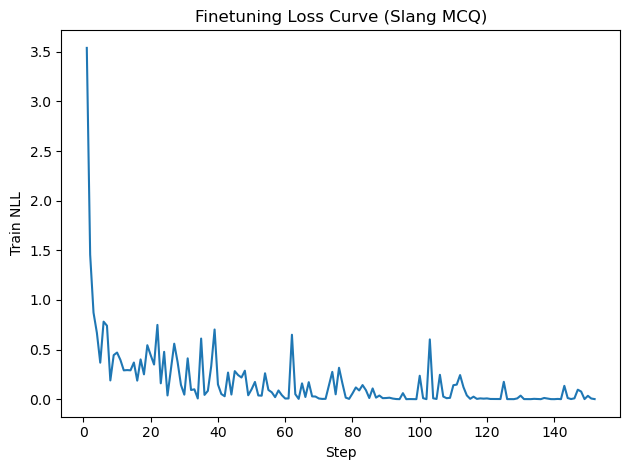

In [18]:
metrics_path = f"logs/{RUN_ID}/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["train_mean_nll"])
plt.xlabel("Step")
plt.ylabel("Train NLL")
plt.title("Finetuning Loss Curve (Slang MCQ)")
plt.tight_layout()
plt.show()

In [20]:
eval_finetuned(
    "data/eval_mcq.csv",
    str(sft_full_resp.path),
    f"logs/{RUN_ID}/finetuned_metrics.json"
)

=== FINETUNED RESULTS ===
Accuracy: 0.8350
Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):
[91, 6, 3, 5]
[3, 74, 1, 4]
[7, 11, 83, 3]
[9, 8, 5, 81]

Classification report:
              precision    recall  f1-score   support

           A       0.83      0.87      0.85       105
           B       0.75      0.90      0.82        82
           C       0.90      0.80      0.85       104
           D       0.87      0.79      0.83       103

    accuracy                           0.84       394
   macro avg       0.84      0.84      0.83       394
weighted avg       0.84      0.84      0.84       394


Saved finetuned metrics to finetuned_metrics.json


In [21]:
service_client = tinker.ServiceClient()
training_client = service_client.create_lora_training_client(base_model=BASE_MODEL)
tokenizer = training_client.get_tokenizer()

FRACTION = 0.25
examples = load_finetune_examples(FINETUNE_PATH)
n_total = len(examples)
n_keep = int(n_total * FRACTION)

rng = np.random.default_rng(SEED)
perm = rng.permutation(n_total)
keep_idx = perm[:n_keep]

examples = [examples[i] for i in keep_idx]

print(f"Using {n_keep}/{n_total} finetune examples (fraction={FRACTION})")
datums = make_datums(examples, tokenizer)

RUN_ID_25p = "forward_mcq_sft_25p"
LOG_DIR = Path("logs/{}".format(RUN_ID_25p))
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

num_epochs = 4
batch_size = 16
learning_rate = 1e-4
global_step = 0

for epoch in range(1, num_epochs + 1):
    print(f"=== Epoch {epoch}/{num_epochs} ===")

    for batch in batch_iter(datums, batch_size=batch_size):
        global_step += 1

        fwdbwd_fut = training_client.forward_backward(batch, "cross_entropy")
        optim_fut = training_client.optim_step(
            types.AdamParams(learning_rate=learning_rate, beta1=0.89, beta2=0.99, eps=1e-8)
        )

        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        # Use built-in loss metric instead of manually handling TensorData
        loss_sum = fwdbwd_res.metrics["loss:sum"]

        # Compute total number of *weighted* tokens for a mean NLL
        total_tokens = 0
        for d in batch:
            w = d.loss_fn_inputs["weights"]  # list or TensorData
            if hasattr(w, "data"):          # handle TensorData just in case
                w_np = np.array(w.data)
            else:
                w_np = np.array(w)
            total_tokens += (w_np > 0).sum()

        mean_nll = float(loss_sum / (total_tokens + 1e-8))

        record = {
            "step": global_step,
            "epoch": epoch,
            "train_loss_sum": float(loss_sum),
            "train_mean_nll": mean_nll,
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | "
                f"train_loss_sum={loss_sum:.4f} | "
                f"train_mean_nll={mean_nll:.4f}"
            )
# Save weights for sampling (for eval_mcq_tinker.py)
sft_25p_resp = await training_client.save_weights_for_sampler(name=RUN_ID_25p)
print("Saved sampler weights at:", sft_25p_resp.path)

Using 151/605 finetune examples (fraction=0.25)
=== Epoch 1/4 ===
step 5 | train_loss_sum=13.5237 | train_mean_nll=0.8452
step 10 | train_loss_sum=1.1213 | train_mean_nll=0.1602
=== Epoch 2/4 ===
step 15 | train_loss_sum=1.8984 | train_mean_nll=0.1187
step 20 | train_loss_sum=0.5229 | train_mean_nll=0.0747
=== Epoch 3/4 ===
step 25 | train_loss_sum=0.3399 | train_mean_nll=0.0212
step 30 | train_loss_sum=0.2668 | train_mean_nll=0.0381
=== Epoch 4/4 ===
step 35 | train_loss_sum=0.0457 | train_mean_nll=0.0029
step 40 | train_loss_sum=0.0004 | train_mean_nll=0.0001
Saved sampler weights at: tinker://58930df4-3dc7-54f9-a549-ceef54854476:train:0/sampler_weights/forward_mcq_sft_25p


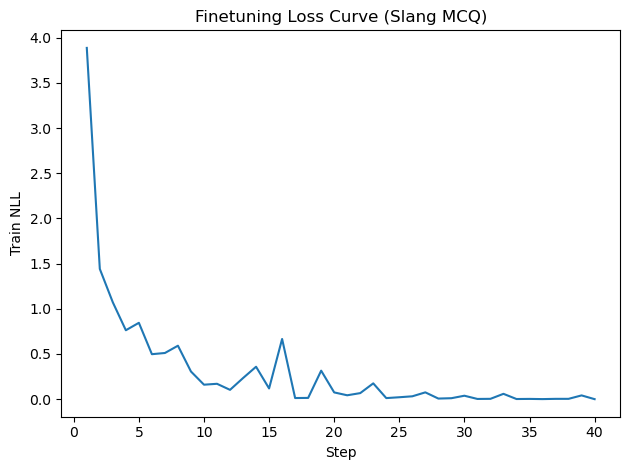

In [22]:
metrics_path = f"logs/{RUN_ID_25p}/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["train_mean_nll"])
plt.xlabel("Step")
plt.ylabel("Train NLL")
plt.title("Finetuning Loss Curve (Slang MCQ)")
plt.tight_layout()
plt.show()

In [23]:
eval_finetuned(
    "data/eval_mcq.csv",
    str(sft_25p_resp.path),
    f"logs/{RUN_ID_25p}/finetuned_metrics.json"
)

=== FINETUNED RESULTS ===
Accuracy: 0.7487
Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):
[82, 11, 4, 8]
[11, 64, 3, 4]
[10, 10, 73, 11]
[12, 8, 7, 76]

Classification report:
              precision    recall  f1-score   support

           A       0.71      0.78      0.75       105
           B       0.69      0.78      0.73        82
           C       0.84      0.70      0.76       104
           D       0.77      0.74      0.75       103

    accuracy                           0.75       394
   macro avg       0.75      0.75      0.75       394
weighted avg       0.76      0.75      0.75       394


Saved finetuned metrics to finetuned_metrics.json


In [24]:
service_client = tinker.ServiceClient()
training_client = service_client.create_lora_training_client(base_model=BASE_MODEL)
tokenizer = training_client.get_tokenizer()

FRACTION = 0.50
examples = load_finetune_examples(FINETUNE_PATH)
n_total = len(examples)
n_keep = int(n_total * FRACTION)

rng = np.random.default_rng(SEED)
perm = rng.permutation(n_total)
keep_idx = perm[:n_keep]

examples = [examples[i] for i in keep_idx]

print(f"Using {n_keep}/{n_total} finetune examples (fraction={FRACTION})")
datums = make_datums(examples, tokenizer)

RUN_ID_50p = "forward_mcq_sft_50p"
LOG_DIR = Path("logs/{}".format(RUN_ID_50p))
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

num_epochs = 4
batch_size = 16
learning_rate = 1e-4
global_step = 0

for epoch in range(1, num_epochs + 1):
    print(f"=== Epoch {epoch}/{num_epochs} ===")

    for batch in batch_iter(datums, batch_size=batch_size):
        global_step += 1

        fwdbwd_fut = training_client.forward_backward(batch, "cross_entropy")
        optim_fut = training_client.optim_step(
            types.AdamParams(learning_rate=learning_rate, beta1=0.89, beta2=0.99, eps=1e-8)
        )

        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        # Use built-in loss metric instead of manually handling TensorData
        loss_sum = fwdbwd_res.metrics["loss:sum"]

        # Compute total number of *weighted* tokens for a mean NLL
        total_tokens = 0
        for d in batch:
            w = d.loss_fn_inputs["weights"]  # list or TensorData
            if hasattr(w, "data"):          # handle TensorData just in case
                w_np = np.array(w.data)
            else:
                w_np = np.array(w)
            total_tokens += (w_np > 0).sum()

        mean_nll = float(loss_sum / (total_tokens + 1e-8))

        record = {
            "step": global_step,
            "epoch": epoch,
            "train_loss_sum": float(loss_sum),
            "train_mean_nll": mean_nll,
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | "
                f"train_loss_sum={loss_sum:.4f} | "
                f"train_mean_nll={mean_nll:.4f}"
            )
# Save weights for sampling (for eval_mcq_tinker.py)
sft_50p_resp = await training_client.save_weights_for_sampler(name=RUN_ID_50p)
print("Saved sampler weights at:", sft_50p_resp.path)

Using 302/605 finetune examples (fraction=0.5)
=== Epoch 1/4 ===
step 5 | train_loss_sum=6.1742 | train_mean_nll=0.3859
step 10 | train_loss_sum=7.9649 | train_mean_nll=0.4978
step 15 | train_loss_sum=4.8325 | train_mean_nll=0.3020
=== Epoch 2/4 ===
step 20 | train_loss_sum=2.5081 | train_mean_nll=0.1568
step 25 | train_loss_sum=1.3331 | train_mean_nll=0.0833
step 30 | train_loss_sum=2.3116 | train_mean_nll=0.1445
step 35 | train_loss_sum=0.6759 | train_mean_nll=0.0422
=== Epoch 3/4 ===
step 40 | train_loss_sum=0.2245 | train_mean_nll=0.0140
step 45 | train_loss_sum=0.3387 | train_mean_nll=0.0212
step 50 | train_loss_sum=0.0429 | train_mean_nll=0.0027
step 55 | train_loss_sum=0.0331 | train_mean_nll=0.0021
=== Epoch 4/4 ===
step 60 | train_loss_sum=0.1653 | train_mean_nll=0.0103
step 65 | train_loss_sum=0.1581 | train_mean_nll=0.0099
step 70 | train_loss_sum=0.0244 | train_mean_nll=0.0015
step 75 | train_loss_sum=0.1819 | train_mean_nll=0.0114
Saved sampler weights at: tinker://bf837af

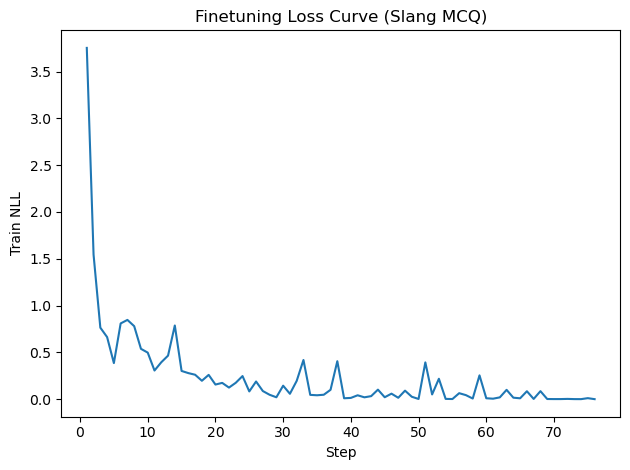

In [25]:
metrics_path = f"logs/{RUN_ID_50p}/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["train_mean_nll"])
plt.xlabel("Step")
plt.ylabel("Train NLL")
plt.title("Finetuning Loss Curve (Slang MCQ)")
plt.tight_layout()
plt.show()

In [26]:
eval_finetuned(
    "data/eval_mcq.csv",
    str(sft_50p_resp.path),
    f"logs/{RUN_ID_50p}/finetuned_metrics.json"
)

=== FINETUNED RESULTS ===
Accuracy: 0.7817
Confusion matrix (rows=true, cols=pred; labels=A,B,C,D):
[89, 6, 4, 6]
[10, 67, 1, 4]
[9, 10, 80, 5]
[14, 9, 8, 72]

Classification report:
              precision    recall  f1-score   support

           A       0.73      0.85      0.78       105
           B       0.73      0.82      0.77        82
           C       0.86      0.77      0.81       104
           D       0.83      0.70      0.76       103

    accuracy                           0.78       394
   macro avg       0.79      0.78      0.78       394
weighted avg       0.79      0.78      0.78       394


Saved finetuned metrics to finetuned_metrics.json


Session heartbeat failed for 22507.204000000027 seconds for session 17c58130-dc39-5164-8650-fd455a45a0ce. Last exception: APIConnectionError: Connection error..
Your connection may be unreliable or Tinker is down. If this persists, the session will be terminated.
Session heartbeat failed for 22508.266000000003 seconds for session 06693052-e1f5-5c72-a286-762e18750800. Last exception: APIConnectionError: Connection error..
Your connection may be unreliable or Tinker is down. If this persists, the session will be terminated.
Session heartbeat failed for 22508.343999999983 seconds for session 58930df4-3dc7-54f9-a549-ceef54854476. Last exception: APIConnectionError: Connection error..
Your connection may be unreliable or Tinker is down. If this persists, the session will be terminated.
Session heartbeat failed for 22508.046999999962 seconds for session ce68ea0d-6529-5fe8-8443-b14916b24c71. Last exception: APIConnectionError: Connection error..
Your connection may be unreliable or Tinker is 